In [1]:
import numpy as np
from math import sqrt,ceil, floor

# Intialize the parameters for a four regime model

In [2]:
sigma = np.array([0.9,0.5,0.7,0.2])
r = np.array([0.02,0.1,0.06,0.15])
a = r-0.5*sigma**2

In [3]:
T= 1
N = 1000
step = T/N
sigma_ = 0.4
b= 4
m = 4 # number of regimes

# intialize the markov chain
Q = np.ones((m,m))/3
for i in range(m):
    Q[i,i] = -1
print('Q\n',Q)

Pa = np.zeros((m,m))
for i in range(m):
    for j in range(m):
        if i!=j:
            Pa[i,j]= -(1-np.exp(Q[i,i]*step))*Q[i,j]/Q[i,i]
        else:
            Pa[i,i]= np.exp(Q[i,i]*step)
print('Transition matrix\n',Pa)

Q
 [[-1.          0.33333333  0.33333333  0.33333333]
 [ 0.33333333 -1.          0.33333333  0.33333333]
 [ 0.33333333  0.33333333 -1.          0.33333333]
 [ 0.33333333  0.33333333  0.33333333 -1.        ]]
Transition matrix
 [[9.99000500e-01 3.33166722e-04 3.33166722e-04 3.33166722e-04]
 [3.33166722e-04 9.99000500e-01 3.33166722e-04 3.33166722e-04]
 [3.33166722e-04 3.33166722e-04 9.99000500e-01 3.33166722e-04]
 [3.33166722e-04 3.33166722e-04 3.33166722e-04 9.99000500e-01]]


In [4]:
K = 100
So = 120

# define the li so that the probabilities of up,middle, down are all positives
L = [0]*m
for i in range (m):
    k1,k2 = floor(2*sigma[i]/sigma_),ceil(2*sigma[i]/sigma_)
    if k1==k2 or k1*sigma_<sigma[i]:
        L[i] = k2
    else:
        c = ((k1*sigma_)**2-sigma[i]**2)/a[i]**2
        d = (k2*sigma_-sqrt((k2*sigma_)**2-4*sigma[i]**2))**2/(4*a[i])**2
        if c<=d:
            L[i] = k2
        else:
            L[i] = k1
print("The increments Li", L)

def compute_Pi(i,li):
    if li ==0:
        return np.array([0,1,0])
    piu = (sigma[i]**2+a[i]*li*sigma_*sqrt(step)+a[i]**2*step)/(2*(li*sigma_)**2)
    pim = 1-(sigma[i]**2+step*a[i]**2)/((li*sigma_)**2)
    pid=1-piu-pim
    return np.array([piu,pim,pid])

The increments Li [4, 2, 3, 1]


In [5]:
def european_prices(L,K,So):

    # check that the li are defined properly
    for i in range(m):
        if not (sigma[i]<L[i]*sigma_<=2*sigma[i] and step<=((L[i]*sigma_)**2-sigma[i]**2)/a[i]**2) or (L[i]*sigma_>2*sigma[i] and step<=(L[i]*sigma_-sqrt((L[i]*sigma_)**2-4*sigma[i]**2))**2/(4*a[i])**2):
            print('Negative branch probabilities')
            return None
        
    Pi =[compute_Pi(i,L[i]) for i in range(m) ]
    print("Probabilities of up,middle, down", Pi)
    
    # intialize the paths 
    Prices = {} #struture of Prices is Prices[time][(x,regime)]
    Prices[0] = {}
    for i in range(m):
        Prices[0][(0,i)] = 0
    for time in range(1,N+1):
        Prices[time] = {}
        for key in Prices[time-1]:
            x,j = key
            for i in range(m):
                for j in range(m):
                    for move in range(-1,2):
                            Prices[time][(x+move*L[i],j)] = 0

    print('Initialization done')

    # compute the Prices backward
    time = N
    for key in Prices[time]:
        x,j = key
        Prices[time][key] = max(0,K-So*np.exp(x*sigma_*sqrt(step)))
    
    for n in range(1,N+1):
        time = N-n
        for key in Prices[time]:
            x,i = key
            summ = 0
            for j in range(m):
                    summ+= Pa[i,j]*(Prices[time+1][(x+L[i],j)]*Pi[i][0]+ \
                                    Prices[time+1][(x-L[i],j)]*Pi[i][2] +\
                                    Prices[time+1][(x,j)]*Pi[i][1]
                    )
            Prices[time][(x,i)] = np.exp(-r[i]*step)*summ
      
    return Prices
    

In [6]:
def american_prices(L,K,So):

    for i in range(m):
        if not (sigma[i]<L[i]*sigma_<=2*sigma[i] and step<=((L[i]*sigma_)**2-sigma[i]**2)/a[i]**2) or (L[i]*sigma_>2*sigma[i] and step<=(L[i]*sigma_-sqrt((L[i]*sigma_)**2-4*sigma[i]**2))**2/(4*a[i])**2):
            print('Negative branch probabilities')
            return None
        
    Pi =[compute_Pi(i,L[i]) for i in range(m) ]
    print(Pi)

    Prices = {} #struture of Prices is Prices[time][(x,regime)]
    Prices[0] = {}
    for i in range(m):
        Prices[0][(0,i)] = 0
    for time in range(1,N+1):
        Prices[time] = {}
        for key in Prices[time-1]:
            x,j = key
            for i in range(m):
                for j in range(m):
                    for move in range(-1,2):
                            Prices[time][(x+move*L[i],j)] = 0

    print('Initialization done')
    
    # compute the Prices backward
    time = N
    for key in Prices[time]:
        x,j = key
        Prices[time][key] = max(0,K-So*np.exp(x*sigma_*sqrt(step)))
    
    for n in range(1,N+1):
        time = N-n
        for key in Prices[time]:
            x,i = key
            summ = 0
            for j in range(m):
                    summ+= Pa[i,j]*(Prices[time+1][(x+L[i],j)]*Pi[i][0]+ \
                                    Prices[time+1][(x-L[i],j)]*Pi[i][2] +\
                                    Prices[time+1][(x,j)]*Pi[i][1]
                    )
            Prices[time][(x,i)] = max(K-So*np.exp(x*sigma_*sqrt(step)),np.exp(-r[i]*step)*summ)
      
    return Prices
    

In [7]:
Euro_Prices_ = european_prices(L,K,So)


Probabilities of up,middle, down [array([0.15442746, 0.68353585, 0.16203669]), array([0.19481888, 0.60937402, 0.19580709]), array([0.16771318, 0.65969845, 0.17258836]), array([0.13019151, 0.74989438, 0.11991411])]
Initialization done


In [8]:
American_Prices = american_prices(L,K,So)

[array([0.15442746, 0.68353585, 0.16203669]), array([0.19481888, 0.60937402, 0.19580709]), array([0.16771318, 0.65969845, 0.17258836]), array([0.13019151, 0.74989438, 0.11991411])]
Initialization done


In [9]:
Euro_Prices_[0]

{(0, 0): 21.798179190150712,
 (0, 1): 11.376347880267724,
 (0, 2): 16.281027290491487,
 (0, 3): 6.579941080242432}

In [10]:
American_Prices[0]

{(0, 0): 22.549092553669,
 (0, 1): 11.90334773259142,
 (0, 2): 16.951597956038007,
 (0, 3): 6.779241622201933}

# Some plots

In [11]:
import matplotlib.pyplot as plt

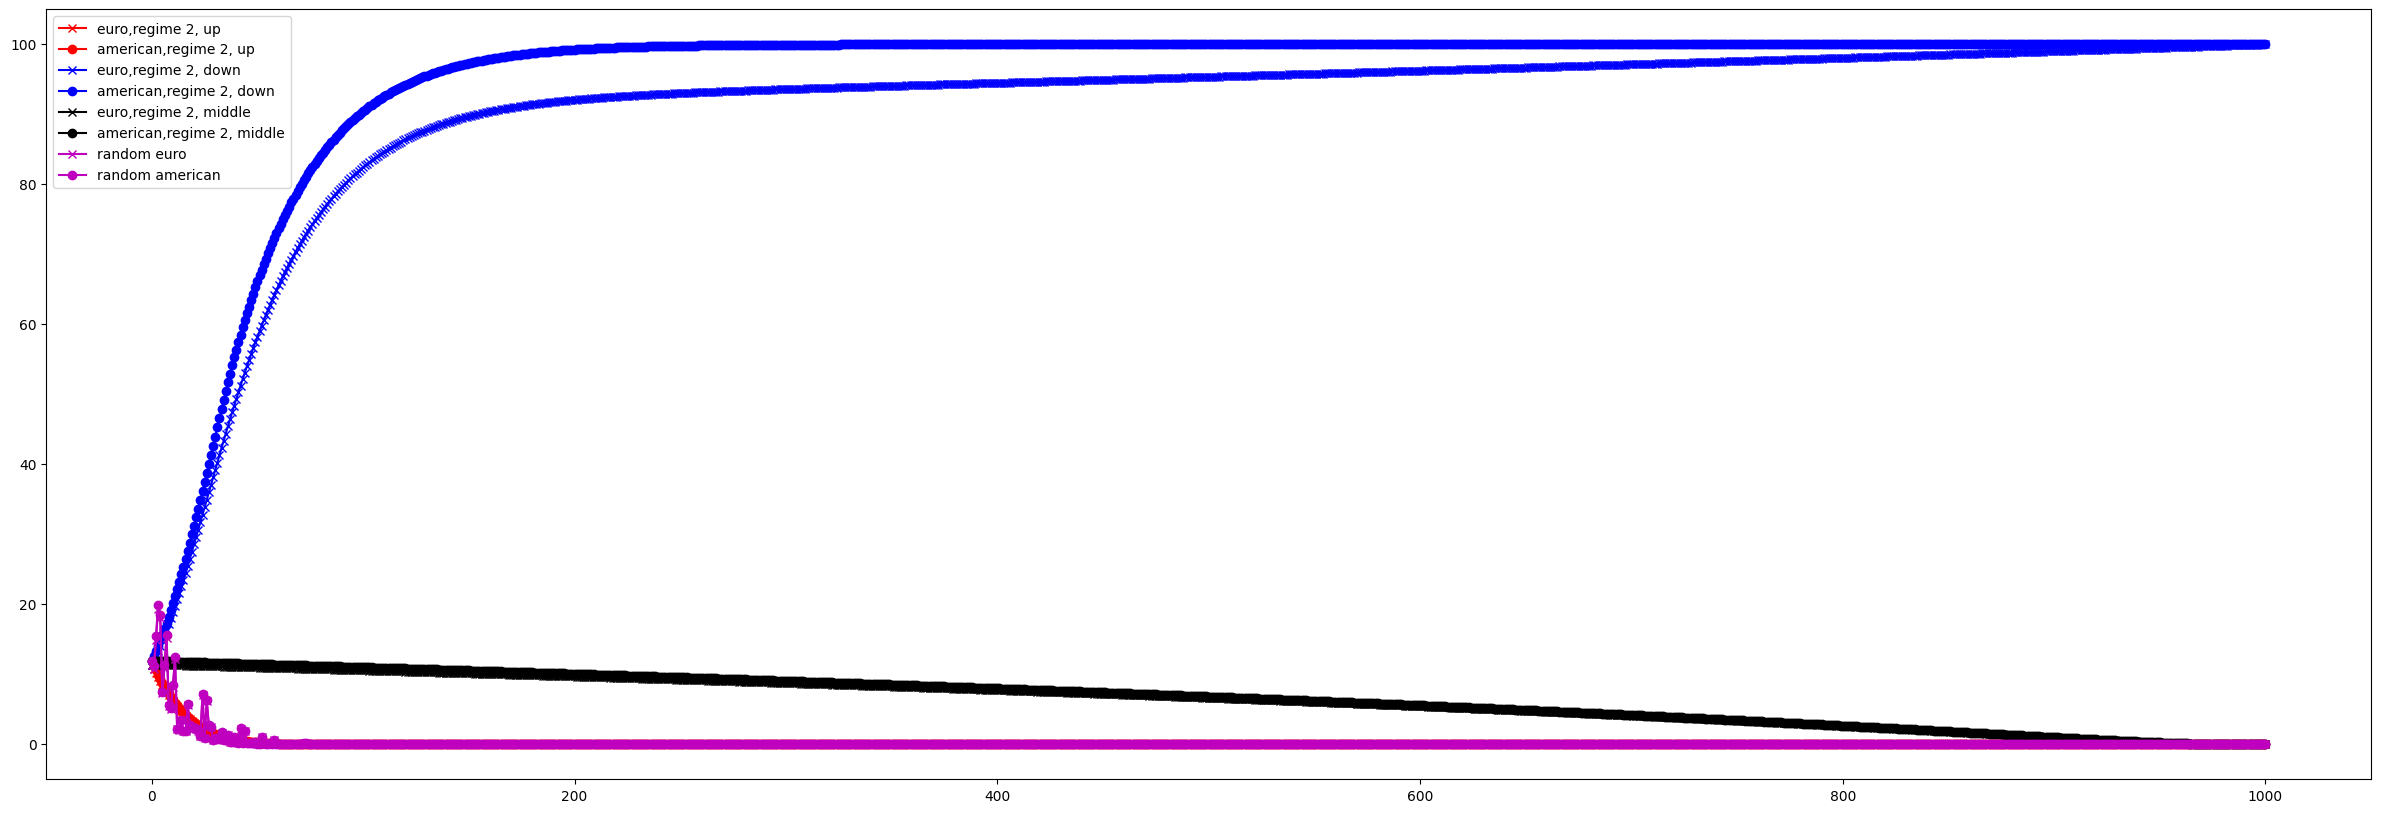

In [12]:
plt.figure(figsize=(30,10))
plt.plot(list(range(0,N+1)),[Euro_Prices_[time][(time*L[1],1)] for time in range(N+1)],color= 'r',marker = 'x',label = 'euro,regime 2, up')
plt.plot(list(range(0,N+1)),[American_Prices[time][(time*L[1],1)] for time in range(N+1)],color= 'r',marker = 'o',label = 'american,regime 2, up')
plt.plot(list(range(0,N+1)),[Euro_Prices_[time][(-time*L[1],1)] for time in range(N+1)],color= 'b',marker = 'x',label = 'euro,regime 2, down')
plt.plot(list(range(0,N+1)),[American_Prices[time][(-time*L[1],1)] for time in range(N+1)],color= 'b',marker = 'o',label = 'american,regime 2, down')
plt.plot(list(range(0,N+1)),[Euro_Prices_[time][(0,1)] for time in range(N+1)],color= 'k',marker = 'x',label = 'euro,regime 2, middle')
plt.plot(list(range(0,N+1)),[American_Prices[time][(0,1)] for time in range(N+1)],color= 'k',marker = 'o',label = 'american,regime 2, middle')
path = np.random.randint(0,m,N+1)
path[0] = 1  #use the same initial regime as for the other plots
interest = np.cumsum([0]+[L[path[i]] for i in range(N)])
plt.plot(list(range(0,N+1)),[Euro_Prices_[time][(interest[time],path[time])] for time in range(N+1)],color= 'm',marker = 'x',label = 'random euro')
plt.plot(list(range(0,N+1)),[American_Prices[time][(interest[time],path[time])] for time in range(N+1)],color= 'm',marker = 'o',label = 'random american')
plt.legend()
#plt.xlim(-10,200)
#plt.ylim(0,17)g

From our transition matrix it is more probable to stay on the middle. That is why the random path converges to a price of zero (the initial price does not change much, so the payoff of the option is null)